# GCP Storage Dataset Instructions

In [3]:
from google.cloud import storage
from tqdm import tqdm
import numpy as np

In [4]:
from google.colab import auth
auth.authenticate_user()

ModuleNotFoundError: No module named 'google.colab'

## Bucket Details



*   **Storage bucket**: https://console.cloud.google.com/storage/browser/rs_storage_open
*   **Read me**: https://console.cloud.google.com/storage/browser/_details/rs_storage_open/README.md



In [ ]:
BUCKET_NAME = 'rs_storage_open'

## Access Datasets

### Folder Structure

In [ ]:
import googleapiclient.discovery

def list_sub_directories(bucket_name, prefix, recursive=True):
    """Returns a list of sub-directories within the given bucket."""
    service = googleapiclient.discovery.build('storage', 'v1')

    req = service.objects().list(bucket=bucket_name, prefix=prefix, delimiter='/')
    res = req.execute()

    # Get the immediate subdirectories
    subdirectories = res.get('prefixes', [])

    if recursive:
        # Recursively get subdirectories for each immediate subdirectory
        additional_subdirectories = []
        for subdirectory in subdirectories:
            additional_subdirectories.extend(list_sub_directories(bucket_name, subdirectory, recursive=True))

        return subdirectories + additional_subdirectories
    else:
        return subdirectories

In [ ]:
# For the example (gs://abc/xyz), bucket_name is 'abc' and the prefix would be 'xyz/'
prefix = ''

result = list_sub_directories(bucket_name=BUCKET_NAME, prefix=prefix)
print(result)

HttpError: ignored

In [ ]:
result = list_sub_directories(bucket_name=BUCKET_NAME, prefix=prefix, recursive=False)
print(result)

['benthic_datasets/']


### Image/Mask example

In [ ]:
def display_image_mask(image, mask):
    """Display the image and mask side by side."""
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

    plt.show()

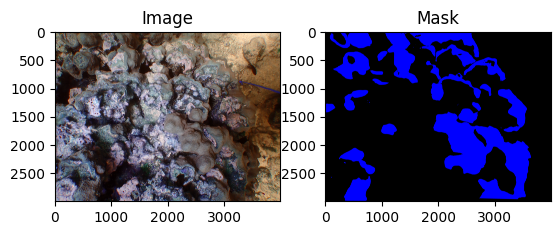

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.cloud import storage

client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

# Replace 'benthic_datasets/mask_labels/rs_labelled/SEAFLOWER_BOLIVAR/images/example_image.jpg' with the path to your image
image_name = '20220912_AnB_CB10 (103)'
image_blob = bucket.blob(f'benthic_datasets/mask_labels/rs_labelled/SEAFLOWER_BOLIVAR/images/{image_name}.JPG')

# Download the image
image_content = image_blob.download_as_bytes()

# Replace 'benthic_datasets/mask_labels/rs_labelled/SEAFLOWER_BOLIVAR/masks_stitched/example_mask.jpg' with the path to your mask
mask_blob = bucket.blob(f'benthic_datasets/mask_labels/rs_labelled/SEAFLOWER_BOLIVAR/masks_stitched/{image_name}_mask.png')

# Download the mask
mask_content = mask_blob.download_as_bytes()

# Decode the image and mask
image = cv2.imdecode(np.frombuffer(image_content, np.uint8), cv2.IMREAD_UNCHANGED)
mask = cv2.imdecode(np.frombuffer(mask_content, np.uint8), cv2.IMREAD_UNCHANGED)


# Visualize the image and mask
display_image_mask(image, mask)

### Pytorch Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import cv2
from tqdm import tqdm

class BenthicDataset(Dataset):
    def __init__(self, bucket_name, folder_path, consider_subfolders=False, resize_size=(256, 256), transform=None, verbose=False):
        self.verbose = verbose
        self.bucket_name = bucket_name
        self.folder_path = folder_path
        self.consider_subfolders = consider_subfolders
        self.resize_size = resize_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(self.resize_size),
            transform
        ])

        if self.verbose:
            print(f"Initializing BenthicDataset with bucket_name: {bucket_name}, folder_path: {folder_path}, consider_subfolders: {consider_subfolders}")

        client = storage.Client()
        bucket = client.get_bucket(bucket_name)

        # Get the list of subfolders if considering subfolders
        if consider_subfolders:
            if self.verbose:
                print("Getting list of subdirectories...")
            self.subfolders = list_sub_directories(bucket_name, folder_path, recursive=False)
        else:
            self.subfolders = ['']

        if self.verbose:
          print("Subfolders", self.subfolders)
          print("Getting list of image and mask files...")

        # Initialize lists to store image and mask files
        self.image_files = []
        self.mask_files = []

        # Populate the image and mask file lists for all subfolders
        for subfolder in tqdm(self.subfolders):
            subfolder_name = subfolder.split('/')[-2]
            if self.verbose:
                print("Subfolder", f'{folder_path}{subfolder_name}')
            self.image_files += bucket.list_blobs(prefix=f'{folder_path}{subfolder_name}/images/')
            self.mask_files += bucket.list_blobs(prefix=f'{folder_path}{subfolder_name}/masks_stitched/')

        if self.verbose:
            print(f"Dataset initialized with {len(self.image_files)} images.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the blob paths for the current index
        current_image_blob = self.image_files[idx]
        current_mask_blob = self.mask_files[idx]

        # Load image and mask
        image_content = current_image_blob.download_as_bytes()
        mask_content = current_mask_blob.download_as_bytes()

        image = cv2.imdecode(np.frombuffer(image_content, np.uint8), cv2.IMREAD_UNCHANGED)
        mask = cv2.imdecode(np.frombuffer(mask_content, np.uint8), cv2.IMREAD_UNCHANGED)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# Example Dataset Creation
bucket_name = BUCKET_NAME
folder_path = 'benthic_datasets/mask_labels/rs_labelled/'  # If specific subfolder (e.g., 'SEAVIEW_ATL'), specify here (e.g., 'benthic_datasets/mask_labels/rs_labelled/SEAVIEW_ATL/') and flag false below
consider_subfolders = True  # Set to False if you don't want to consider subfolders and specify a specific subfolder in folder_path instead

transform = transforms.Compose([
    # Add other transformations as needed
])

resize_size = (256, 256)  # Specify the desired size

benthic_dataset = BenthicDataset(bucket_name, folder_path, consider_subfolders, resize_size=resize_size, transform=transform, verbose=True)


Initializing BenthicDataset with bucket_name: rs_storage_open, folder_path: benthic_datasets/mask_labels/rs_labelled/, consider_subfolders: True
Getting list of subdirectories...
Subfolders ['benthic_datasets/mask_labels/rs_labelled/SEAFLOWER_BOLIVAR/', 'benthic_datasets/mask_labels/rs_labelled/SEAFLOWER_COURTOWN/', 'benthic_datasets/mask_labels/rs_labelled/SEAVIEW_ATL/', 'benthic_datasets/mask_labels/rs_labelled/SEAVIEW_IDN_PHL/', 'benthic_datasets/mask_labels/rs_labelled/SEAVIEW_PAC_AUS/', 'benthic_datasets/mask_labels/rs_labelled/SEAVIEW_PAC_USA/', 'benthic_datasets/mask_labels/rs_labelled/TETES_PROVIDENCIA/']
Getting list of image and mask files...


  0%|          | 0/7 [00:00<?, ?it/s]

Subfolder benthic_datasets/mask_labels/rs_labelled/SEAFLOWER_BOLIVAR


 14%|█▍        | 1/7 [00:00<00:05,  1.15it/s]

Subfolder benthic_datasets/mask_labels/rs_labelled/SEAFLOWER_COURTOWN


 29%|██▊       | 2/7 [00:01<00:03,  1.28it/s]

Subfolder benthic_datasets/mask_labels/rs_labelled/SEAVIEW_ATL


 43%|████▎     | 3/7 [00:02<00:03,  1.15it/s]

Subfolder benthic_datasets/mask_labels/rs_labelled/SEAVIEW_IDN_PHL


 57%|█████▋    | 4/7 [00:03<00:02,  1.10it/s]

Subfolder benthic_datasets/mask_labels/rs_labelled/SEAVIEW_PAC_AUS


 71%|███████▏  | 5/7 [00:04<00:01,  1.06it/s]

Subfolder benthic_datasets/mask_labels/rs_labelled/SEAVIEW_PAC_USA


 86%|████████▌ | 6/7 [00:05<00:00,  1.06it/s]

Subfolder benthic_datasets/mask_labels/rs_labelled/TETES_PROVIDENCIA


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

Dataset initialized with 3299 images.


  0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


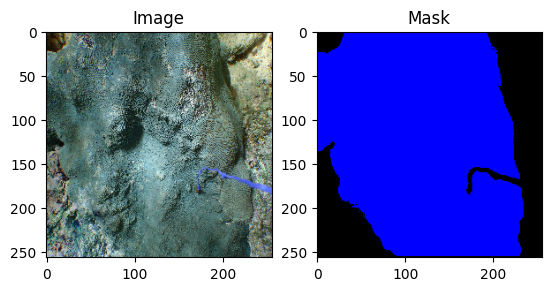

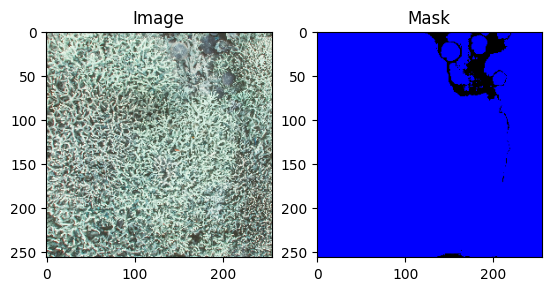

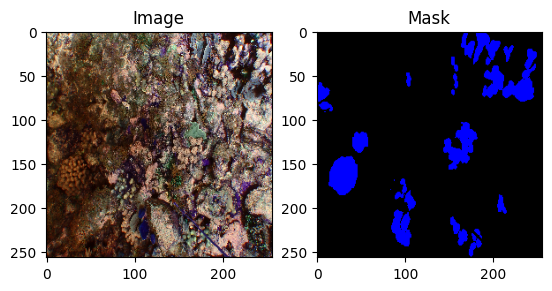

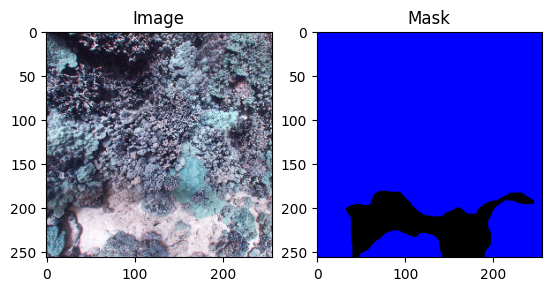

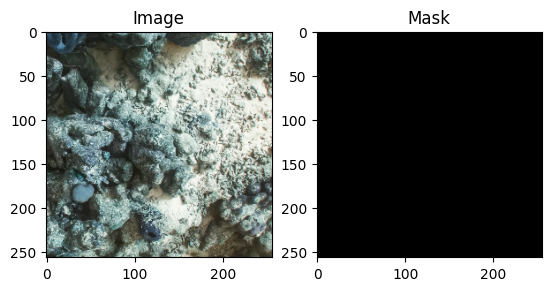

  0%|          | 0/104 [00:49<?, ?it/s]


In [ ]:
import torchvision.transforms.functional as F

# Example Dataloader creation
data_loader = DataLoader(benthic_dataset, batch_size=32, shuffle=True)

# Display the first five tuple of image and mask
for batch in tqdm(data_loader):
  images, masks = batch
  for i in range(0, min(len(images), 5)):
    image = F.to_pil_image(images[i])
    mask = F.to_pil_image(masks[i])
    display_image_mask(image, mask)
  break